In [3]:
%matplotlib inline
import numpy as np
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_rel
import cv2
import matplotlib.image
import matplotlib.pyplot as plt
import h5py
import math
import os

img_ids = ['G1/G101', 'G1/G120', 'G2/G201', 'G2/G220', 'G3/G301', 'G3/G320', 'G4/G401', 'G4/G420', 'G5/G501', 'G5/G520',
          'L1/L101', 'L1/L120', 'L2/L201', 'L2/L220', 'L3/L301', 'L3/L320', 'L4/L401', 'L4/L420', 'L5/L501', 'L5/L520']
for img_id in img_ids:
    img = cv2.imread('Novel_Objects/' + img_id + '.jpg')
    img_resize = cv2.resize(img, (100, 100))
    cv2.imwrite('Novel_Objects/' + img_id + '_resized.jpg', img_resize)

def addnoisetoimg(img, noise_c):
    y, x = np.shape(img)
    Ms = np.ones([100, y, x])
    for k in range(100):
        index = 1 if np.random.rand()>0.5 else -1
        randomx = index*(int(np.random.rand()*noise_c)) 
        randomy = index*(int(np.random.rand()*noise_c))
        if randomx >= 0 and randomy >= 0:
            Ms[k, randomy:, randomx:] = img[:y-randomy, :x-randomx]
        if randomx >= 0 and randomy < 0:
            Ms[k, :y+randomy, randomx:] = img[-randomy:, :x-randomx]
        if randomx < 0 and randomy >= 0:
            Ms[k, randomy:, :x+randomx] = img[:y-randomy, -randomx:]
        if randomx < 0 and randomy < 0:
            Ms[k, :y+randomy, :x+randomx] = img[-randomy:, -randomx:]
    return np.average(Ms, axis=0)

def cal_Mreitno(Vinput, DyState, Mretino_pre=None):
    noise_retino_dy = (np.exp(0.5*DyState) - np.exp(-0.5*DyState)) / (np.exp(0.5*DyState) + np.exp(-0.5*DyState))*250
    noise = noise_retino_dy
    y, x = Vinput.shape
    Ms = np.ones([100, y, x])
    for k in range(100):
        index = 1 if np.random.rand()>0.5 else -1
        randomx = index*(int(np.random.rand()*noise)) 
        randomy = index*(int(np.random.rand()*noise))
        if randomx >= 0 and randomy >= 0:
            Ms[k, randomy:, randomx:] = Vinput[:y-randomy, :x-randomx]
        if randomx >= 0 and randomy < 0:
            Ms[k, :y+randomy, randomx:] = Vinput[-randomy:, :x-randomx]
        if randomx < 0 and randomy >= 0:
            Ms[k, randomy:, :x+randomx] = Vinput[:y-randomy, -randomx:]
        if randomx < 0 and randomy < 0:
            Ms[k, :y+randomy, :x+randomx] = Vinput[-randomy:, -randomx:]
    if Mretino_pre is None:
        return np.average(Ms, axis=0)
    else:
        #return np.average(Ms, axis=0) + 0.5*Mretino_pre - 0.5
        Ms1 = np.zeros([y, x])
        Ms_avg = np.average(Ms, axis=0)
        for i in range(y):
            for j in range(x):
                if Ms_avg[i, j] + Mretino_pre[i, j] < 1:
                    Ms1[i, j] = 0
                else:
                    Ms1[i, j] = Ms_avg[i, j] + Mretino_pre[i, j] - 1
        return Ms1
    
def cal_Mspatio_withstimulus(Mspatio_pre, EyePositionInMSpatio, Vinput, DyState, saccade, noise_c):
    xs, ys = saccade
    y1, x1 = Mspatio_pre.shape
    fx, fy = EyePositionInMSpatio
    y2, x2 = Vinput.shape
    sx = abs(xs)
    sy = abs(ys)
    if xs >= 0 and ys >= 0:
        if sy + int(0.5*y2) > fy:
            if sx + int(0.5*x2) > x1 - fx:
                M1 = np.ones([y1-fy+sy+int(0.5*y2), fx+sx+int(0.5*x2)])
                M2 = np.ones([y1-fy+sy+int(0.5*y2), fx+sx+int(0.5*x2)])
                M1[-fy+sy+int(0.5*y2):, :x1] = Mspatio_pre
                M2[:y2, fx+sx-int(0.5*x2):] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, int(0.5*y2)])
            else:
                M1 = np.ones([y1-fy+sy+int(0.5*y2), x1])
                M2 = np.ones([y1-fy+sy+int(0.5*y2), x1])
                M1[-fy+sy+int(0.5*y2):, :] = Mspatio_pre
                M2[:y2, fx+sx-int(0.5*x2):fx+sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, int(0.5*y2)])
        else:
            if sx + int(0.5*x2) > x1 - fx:
                M1 = np.ones([y1, fx+sx+int(0.5*x2)])
                M2 = np.ones([y1, fx+sx+int(0.5*x2)])
                M1[:, :x1] = Mspatio_pre
                M2[fy-sy-int(0.5*x2):fy-sy+int(0.5*x2), fx+sx-int(0.5*x2):] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy-sy])
            else:
                M1 = np.ones([y1, x1])
                M2 = np.ones([y1, x1])
                M1[:, :] = Mspatio_pre
                M2[fy-sy-int(0.5*x2):fy-sy+int(0.5*x2), fx+sx-int(0.5*x2):fx+sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy-sy])
    if xs >= 0 and ys < 0:
        if sy + int(0.5*y2) > y1 - fy:
            if sx + int(0.5*x2) > x1 - fx:
                M1 = np.ones([fy+sy+int(0.5*y2), fx+sx+int(0.5*x2)])
                M2 = np.ones([fy+sy+int(0.5*y2), fx+sx+int(0.5*x2)])
                M1[:y1, :x1] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):, fx+sx-int(0.5*x2):] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy+sy])
            else:
                M1 = np.ones([fy+sy+int(0.5*y2), x1])
                M2 = np.ones([fy+sy+int(0.5*y2), x1])
                M1[:y1, :] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):, fx+sx-int(0.5*x2):fx+sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy+sy])
        else:
            if sx + int(0.5*x2) > x1 - fx:
                M1 = np.ones([y1, fx+sx+int(0.5*x2)])
                M2 = np.ones([y1, fx+sx+int(0.5*x2)])
                M1[:, :x1] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):fy+sy+int(0.5*y2), fx+sx-int(0.5*x2):] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy+sy])
            else:
                M1 = np.ones([y1, x1])
                M2 = np.ones([y1, x1])
                M1[:, :] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):fy+sy+int(0.5*y2), fx+sx-int(0.5*x2):fx+sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy+sy])
    if xs < 0 and ys >= 0:
        if sy + int(0.5*y2) > fy:
            if sx + int(0.5*x2) > fx:
                M1 = np.ones([y1+sy-fy+int(0.5*y2), x1+sx-fx+int(0.5*x2)])
                M2 = np.ones([y1+sy-fy+int(0.5*y2), x1+sx-fx+int(0.5*x2)])
                M1[sy-fy+int(0.5*y2):, sx-fx+int(0.5*x2):] = Mspatio_pre
                M2[:y2, :x2] = Vinput
                NewEyePositionInMSpatio = np.array([int(0.5*x2), int(0.5*y2)])
            else:
                M1 = np.ones([y1+sy-fy+int(0.5*y2), x1])
                M2 = np.ones([y1+sy-fy+int(0.5*y2), x1])
                M1[sy-fy+int(0.5*y2):, :] = Mspatio_pre
                M2[:y2, fx-sx-int(0.5*x2):fx-sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx-sx, int(0.5*y2)])
        else:
            if sx + int(0.5*x2) > fx:
                M1 = np.ones([y1, x1+sx-fx+int(0.5*x2)])
                M2 = np.ones([y1, x1+sx-fx+int(0.5*x2)])
                M1[:, sx-fx+int(0.5*x2):] = Mspatio_pre
                M2[fy-sy-int(0.5*y2):fy-sy+int(0.5*y2), :x2] = Vinput
                NewEyePositionInMSpatio = np.array([int(0.5*x2), fy-sy])
            else:
                M1 = np.ones([y1, x1])
                M2 = np.ones([y1, x1])
                M1[:, :] = Mspatio_pre
                M2[fy-sy-int(0.5*y2):fy-sy+int(0.5*y2), fx-sx-int(0.5*x2):fx-sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx-sx, fy-sy])
    if xs < 0 and ys < 0:
        if sy + int(0.5*y2) < y1 - fy:
            if sx + int(0.5*x2) < fx:
                M1 = np.ones([fy+sy+int(0.5*y2), x1-fx+sx+int(0.5*x2)])
                M2 = np.ones([fy+sy+int(0.5*y2), x1-fx+sx+int(0.5*x2)])
                M1[:y1, -fx+sx+int(0.5*x2):] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):, :x2] = Vinput
                NewEyePositionInMSpatio = np.array([int(0.5*x2), fy+sy])
            else:
                M1 = np.ones([fy+sy+int(0.5*y2), x1])
                M2 = np.ones([fy+sy+int(0.5*y2), x1])
                M1[:y1, :] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):, fx-sx-int(0.5*x2):fx-sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx-sx, fy+sy])
        else:
            if sx + int(0.5*x2) < fx:
                M1 = np.ones([fy+sy+int(0.5*y2), x1])
                M2 = np.ones([fy+sy+int(0.5*y2), x1])
                M1[:, -fx+sx+int(0.5*x2):] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):fy+sy+int(0.5*y2), :x2] = Vinput
                NewEyePositionInMSpatio = np.array([int(0.5*x2), fy+sy])
            else:
                M1 = np.ones([fy+sy+int(0.5*y2), x1])
                M2 = np.ones([fy+sy+int(0.5*y2), x1])
                M1[:, :] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):fy+sy+int(0.5*y2), fx-sx-int(0.5*x2):fx-sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx-sx, fy+sy])
    M_avg = np.ones(np.shape(M1))
    for i in range(np.shape(M1)[0]):
        for j in range(np.shape(M1)[1]):
            if M1[i, j] != 1 and M2[i, j] != 1:
                M_avg[i, j] = 0.5*(M1[i, j] + M2[i, j])
            elif M1[i, j] != 1 and M2[i, j] == 1:
                M_avg[i, j] = M1[i, j]
            elif M1[i, j] == 1 and M2[i, j] != 1:
                M_avg[i, j] = M2[i, j]
    y, x = M_avg.shape
    Ms = np.ones([10, y, x])
    noise_spatio_dy = (1-(np.exp(0.5*DyState) - np.exp(-0.5*DyState)) / (np.exp(0.5*DyState) + np.exp(-0.5*DyState)))*50
    noise = noise_spatio_dy
    for k in range(10):
        index = 1 if np.random.rand()>0.5 else -1
        randomx = index*(int(np.random.rand()*noise)) 
        randomy = index*(int(np.random.rand()*noise))
        if randomx >= 0 and randomy >= 0:
            Ms[k, randomy:, randomx:] = M_avg[:y-randomy, :x-randomx]
        if randomx >= 0 and randomy < 0:
            Ms[k, :y+randomy, randomx:] = M_avg[-randomy:, :x-randomx]
        if randomx < 0 and randomy >= 0:
            Ms[k, randomy:, :x+randomx] = M_avg[:y-randomy, -randomx:]
        if randomx < 0 and randomy < 0:
            Ms[k, :y+randomy, :x+randomx] = M_avg[-randomy:, -randomx:]
    return np.average(Ms, axis=0), NewEyePositionInMSpatio

def cal_Mspatio_withoutstimulus(Mspatio_pre, EyePositionInMSpatio, Vinput, DyState, saccade, noise_c):
    xs, ys = saccade
    y1, x1 = Mspatio_pre.shape
    fx, fy = EyePositionInMSpatio
    y2, x2 = Vinput.shape
    sx = abs(xs)
    sy = abs(ys)
    if xs >= 0 and ys >= 0:
        if sy + int(0.5*y2) > fy:
            if sx + int(0.5*x2) > x1 - fx:
                M1 = np.ones([y1-fy+sy+int(0.5*y2), fx+sx+int(0.5*x2)])
                M2 = np.ones([y1-fy+sy+int(0.5*y2), fx+sx+int(0.5*x2)])
                M1[-fy+sy+int(0.5*y2):, :x1] = Mspatio_pre
                M2[:y2, fx+sx-int(0.5*x2):] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, int(0.5*y2)])
            else:
                M1 = np.ones([y1-fy+sy+int(0.5*y2), x1])
                M2 = np.ones([y1-fy+sy+int(0.5*y2), x1])
                M1[-fy+sy+int(0.5*y2):, :] = Mspatio_pre
                M2[:y2, fx+sx-int(0.5*x2):fx+sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, int(0.5*y2)])
        else:
            if sx + int(0.5*x2) > x1 - fx:
                M1 = np.ones([y1, fx+sx+int(0.5*x2)])
                M2 = np.ones([y1, fx+sx+int(0.5*x2)])
                M1[:, :x1] = Mspatio_pre
                M2[fy-sy-int(0.5*x2):fy-sy+int(0.5*x2), fx+sx-int(0.5*x2):] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy-sy])
            else:
                M1 = np.ones([y1, x1])
                M2 = np.ones([y1, x1])
                M1[:, :] = Mspatio_pre
                M2[fy-sy-int(0.5*x2):fy-sy+int(0.5*x2), fx+sx-int(0.5*x2):fx+sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy-sy])
    if xs >= 0 and ys < 0:
        if sy + int(0.5*y2) > y1 - fy:
            if sx + int(0.5*x2) > x1 - fx:
                M1 = np.ones([fy+sy+int(0.5*y2), fx+sx+int(0.5*x2)])
                M2 = np.ones([fy+sy+int(0.5*y2), fx+sx+int(0.5*x2)])
                M1[:y1, :x1] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):, fx+sx-int(0.5*x2):] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy+sy])
            else:
                M1 = np.ones([fy+sy+int(0.5*y2), x1])
                M2 = np.ones([fy+sy+int(0.5*y2), x1])
                M1[:y1, :] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):, fx+sx-int(0.5*x2):fx+sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy+sy])
        else:
            if sx + int(0.5*x2) > x1 - fx:
                M1 = np.ones([y1, fx+sx+int(0.5*x2)])
                M2 = np.ones([y1, fx+sx+int(0.5*x2)])
                M1[:, :x1] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):fy+sy+int(0.5*y2), fx+sx-int(0.5*x2):] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy+sy])
            else:
                M1 = np.ones([y1, x1])
                M2 = np.ones([y1, x1])
                M1[:, :] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):fy+sy+int(0.5*y2), fx+sx-int(0.5*x2):fx+sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx+sx, fy+sy])
    if xs < 0 and ys >= 0:
        if sy + int(0.5*y2) > fy:
            if sx + int(0.5*x2) > fx:
                M1 = np.ones([y1+sy-fy+int(0.5*y2), x1+sx-fx+int(0.5*x2)])
                M2 = np.ones([y1+sy-fy+int(0.5*y2), x1+sx-fx+int(0.5*x2)])
                M1[sy-fy+int(0.5*y2):, sx-fx+int(0.5*x2):] = Mspatio_pre
                M2[:y2, :x2] = Vinput
                NewEyePositionInMSpatio = np.array([int(0.5*x2), int(0.5*y2)])
            else:
                M1 = np.ones([y1+sy-fy+int(0.5*y2), x1])
                M2 = np.ones([y1+sy-fy+int(0.5*y2), x1])
                M1[sy-fy+int(0.5*y2):, :] = Mspatio_pre
                M2[:y2, fx-sx-int(0.5*x2):fx-sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx-sx, int(0.5*y2)])
        else:
            if sx + int(0.5*x2) > fx:
                M1 = np.ones([y1, x1+sx-fx+int(0.5*x2)])
                M2 = np.ones([y1, x1+sx-fx+int(0.5*x2)])
                M1[:, sx-fx+int(0.5*x2):] = Mspatio_pre
                M2[fy-sy-int(0.5*y2):fy-sy+int(0.5*y2), :x2] = Vinput
                NewEyePositionInMSpatio = np.array([int(0.5*x2), fy-sy])
            else:
                M1 = np.ones([y1, x1])
                M2 = np.ones([y1, x1])
                M1[:, :] = Mspatio_pre
                M2[fy-sy-int(0.5*y2):fy-sy+int(0.5*y2), fx-sx-int(0.5*x2):fx-sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx-sx, fy-sy])
    if xs < 0 and ys < 0:
        if sy + int(0.5*y2) < y1 - fy:
            if sx + int(0.5*x2) < fx:
                M1 = np.ones([fy+sy+int(0.5*y2), x1-fx+sx+int(0.5*x2)])
                M2 = np.ones([fy+sy+int(0.5*y2), x1-fx+sx+int(0.5*x2)])
                M1[:y1, -fx+sx+int(0.5*x2):] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):, :x2] = Vinput
                NewEyePositionInMSpatio = np.array([int(0.5*x2), fy+sy])
            else:
                M1 = np.ones([fy+sy+int(0.5*y2), x1])
                M2 = np.ones([fy+sy+int(0.5*y2), x1])
                M1[:y1, :] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):, fx-sx-int(0.5*x2):fx-sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx-sx, fy+sy])
        else:
            if sx + int(0.5*x2) < fx:
                M1 = np.ones([fy+sy+int(0.5*y2), x1])
                M2 = np.ones([fy+sy+int(0.5*y2), x1])
                M1[:, -fx+sx+int(0.5*x2):] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):fy+sy+int(0.5*y2), :x2] = Vinput
                NewEyePositionInMSpatio = np.array([int(0.5*x2), fy+sy])
            else:
                M1 = np.ones([fy+sy+int(0.5*y2), x1])
                M2 = np.ones([fy+sy+int(0.5*y2), x1])
                M1[:, :] = Mspatio_pre
                M2[fy+sy-int(0.5*y2):fy+sy+int(0.5*y2), fx-sx-int(0.5*x2):fx-sx+int(0.5*x2)] = Vinput
                NewEyePositionInMSpatio = np.array([fx-sx, fy+sy])
    M_comb = np.zeros(np.shape(M1))
    for i in range(np.shape(M1)[0]):
        for j in range(np.shape(M1)[1]):
            if M1[i, j] + M2[i, j] < 1:
                M_comb[i, j] = 0
            else:
                M_comb[i, j] = M1[i, j] + M2[i, j] - 1
    y, x = M_comb.shape
    Ms = np.ones([10, y, x])
    noise_spatio_dy = (1-(np.exp(0.5*DyState) - np.exp(-0.5*DyState)) / (np.exp(0.5*DyState) + np.exp(-0.5*DyState)))*50
    noise = noise_spatio_dy
    for k in range(10):
        index = 1 if np.random.rand()>0.5 else -1
        randomx = index*(int(np.random.rand()*noise)) 
        randomy = index*(int(np.random.rand()*noise))
        if randomx >= 0 and randomy >= 0:
            Ms[k, randomy:, randomx:] = M_comb[:y-randomy, :x-randomx]
        if randomx >= 0 and randomy < 0:
            Ms[k, :y+randomy, randomx:] = M_comb[-randomy:, :x-randomx]
        if randomx < 0 and randomy >= 0:
            Ms[k, randomy:, :x+randomx] = M_comb[:y-randomy, -randomx:]
        if randomx < 0 and randomy < 0:
            Ms[k, :y+randomy, :x+randomx] = M_comb[-randomy:, -randomx:]
    return np.average(Ms, axis=0), NewEyePositionInMSpatio

def generateImage(sinfo, retino_loc):
    img = np.ones([440, 440])
    if sinfo != '999':
        s = np.average(matplotlib.image.imread(sinfo)/255, axis=2)
        x, y = retino_loc
        x = x + 220
        y = 220 - y
        img[y-50:y+50, x-50:x+50] = s
    return img

def addfixation(img, fix_loc):
    x, y = fix_loc
    img[y-1:y+2, x-5:x+6] = 0
    img[y-5:y+6, x-1:x+2] = 0
    return img

def run(Saccades, sinfo, slocs, filename):
    # Saccades: [nts, 2] int-array, EyeMovements Saccades[0]=[0, 0]
    # sinfo: [nts] str-array, stimuli's index
    # slocs: [nts] int-array, stimuli's retinotopic location
    nts = np.shape(Saccades)[0]
    print(nts)
    DyStates = np.zeros([nts], dtype=int)
    noise_c = 5
    inputs = np.zeros([nts, 440, 440])
    EyePositionInMSpatio = np.zeros([nts, 2], dtype=int)
    
    # t = 0
    DyStates[0] = 0
    inputs[0] = addnoisetoimg(generateImage(sinfo[0], slocs[0]), noise_c)
    EyePositionInMSpatio[0] = np.array([220, 220])
    extend = False
    Mretino = cal_Mreitno(inputs[0], DyStates[0], Mretino_pre=None)
    Mspatio = inputs[0]
    
    Mretino_pre = Mretino
    Mspatio_pre = Mspatio
    
    Mretino_now = addfixation(Mretino, [220, 220])
    Mretino_now = np.transpose(np.tile(Mretino_now, (3, 1, 1)), (1, 2, 0))
    matplotlib.image.imsave( filename+'0Mretino.jpg', np.array(Mretino_now, dtype=float))
    Mspatio_now = addfixation(Mspatio, [220, 220])
    Mspatio_now = np.transpose(np.tile(Mspatio_now, (3, 1, 1)), (1, 2, 0))
    matplotlib.image.imsave( filename+'0Mspatio.jpg', np.array(Mspatio_now, dtype=float))
    
    for t in range(nts-1):
        hasSaccade = (Saccades[t+1, 0] != 0) or (Saccades[t+1, 1] != 0)
        if hasSaccade == True:
            DyStates[t+1] = DyStates[t] + 1
        else:
            DyStates[t+1] = DyStates[t]
        inputs[t+1] = addnoisetoimg(generateImage(sinfo[t+1], slocs[t+1]), noise_c)
        Mretino = cal_Mreitno(inputs[t+1], DyStates[t+1], Mretino_pre=Mretino_pre)
        if extend is False:
            if hasSaccade == True and (sinfo[t] != '999') and (sinfo[t+1] != '999'):
                extend = True
            else:
                Mspatio = np.array(inputs[t+1])
                EyePositionInMSpatio[t+1] = EyePositionInMSpatio[t]
        if extend is True:
            if (sinfo[t] != '999') and (sinfo[t+1] != '999'):
                Mspatio, EyePositionInMSpatio[t+1] = cal_Mspatio_withstimulus(Mspatio_pre, EyePositionInMSpatio[t], 
                                                                               inputs[t+1], DyStates[t+1], Saccades[t+1], noise_c)
            else:
                Mspatio, EyePositionInMSpatio[t+1] = cal_Mspatio_withoutstimulus(Mspatio_pre, EyePositionInMSpatio[t], 
                                                                                  inputs[t+1], DyStates[t+1], Saccades[t+1], noise_c)
        
        
        Mretino_pre = Mretino
        Mspatio_pre = Mspatio
        
        # plot
        Mretino_now = addfixation(Mretino, [220, 220])
        Mretino_now = np.transpose(np.tile(Mretino_now, (3, 1, 1)), (1, 2, 0))
        matplotlib.image.imsave( filename+str(t+1)+'Mretino.jpg', np.array(Mretino_now, dtype=float))
        Mspatio_now = addfixation(Mspatio, EyePositionInMSpatio[t+1])
        Mspatio_now = np.transpose(np.tile(Mspatio_now, (3, 1, 1)), (1, 2, 0))
        matplotlib.image.imsave( filename+str(t+1)+'Mspatio.jpg', np.array(Mspatio_now, dtype=float))

    np.savetxt(filename+'_EyePositionInMspatio.txt', EyePositionInMSpatio)

In [6]:
# 8routes * 2s1loc * 4s2loc * 4sameordifferent * 10

sf1f2 = np.array([[-100, 0], [100, 0], [0, 100], [0, -100]])

routes = np.zeros([8, 35, 2])

for i in range(4):
    for j in range(2):
        routes[i*2+j, [4, 12, 20, 32]] = sf1f2[i]
        routes[i*2+j, [8, 16, 28]] = -sf1f2[i]
        if sf1f2[i, 0] == 0:
            if j == 0:
                routes[i*2+j, 24] = [100, 0]
            if j == 1:
                routes[i*2+j, 24] = [-100, 0]
        if sf1f2[i, 1] == 0:
            if j == 0:
                routes[i*2+j, 24] = [0, 100]
            if j == 1:
                routes[i*2+j, 24] = [0, -100]

routes_saccades = np.zeros([8, 35, 2])

for i in range(4):
    for j in range(2):
        if sf1f2[i, 0] == 0:
            if j == 0:
                routes_saccades[i*2+j, 24] = [100, 0]
            if j == 1:
                routes_saccades[i*2+j, 24] = [-100, 0]
        if sf1f2[i, 1] == 0:
            if j == 0:
                routes_saccades[i*2+j, 24] = [0, 100]
            if j == 1:
                routes_saccades[i*2+j, 24] = [0, -100]

family = ['G1', 'G2', 'G3', 'G4', 'G5',
         'L1', 'L2', 'L3', 'L4', 'L5']

saccades = np.zeros([8, 2, 4, 4, 10, 35, 2], dtype=int)
sinfo = np.full([8, 2, 4, 4, 10, 35], '999', dtype=object)
slocs = np.zeros([8, 2, 4, 4, 10, 35, 2], dtype=int)
for i in range(8):
    for j in range(2):
        # 0: spatio; 1: strong retino; 2: control B; 3:control A
        for k in range(4):
            # 01: same, 23: different
            for l in range(4):
                for m in range(10):
                
                    saccades[i, j, k, l, m] = routes_saccades[i]
                    
                    sid1 = '01'
                    sid2 = '20'
                    sfamily = family[m]
                    if l == 0:
                        sinfo[i, j, k, l, m, [11, 12, 31, 32]] = 'Novel_Objects/'+sfamily+'/'+sfamily+sid1+'_resized.jpg'
                    if l == 1:
                        sinfo[i, j, k, l, m, [11, 12, 31, 32]] = 'Novel_Objects/'+sfamily+'/'+sfamily+sid2+'_resized.jpg'
                    if l == 2:
                        sinfo[i, j, k, l, m, [11, 12]] = 'Novel_Objects/'+sfamily+'/'+sfamily+sid1+'_resized.jpg'
                        sinfo[i, j, k, l, m, [31, 32]] = 'Novel_Objects/'+sfamily+'/'+sfamily+sid2+'_resized.jpg'
                    if l == 3:
                        sinfo[i, j, k, l, m, [11, 12]] = 'Novel_Objects/'+sfamily+'/'+sfamily+sid2+'_resized.jpg'
                        sinfo[i, j, k, l, m, [31, 32]] = 'Novel_Objects/'+sfamily+'/'+sfamily+sid1+'_resized.jpg'
                
                    if j == 0:
                        slocs[i, j, k, l, m, [11, 12]] = 0.5*routes[i, 4] + 0.5*routes[i, 24]
                    if j == 1:
                        slocs[i, j, k, l, m, [11, 12]] = -0.5*routes[i, 4] + 0.5*routes[i, 24]
                
                    if k == 0:
                        slocs[i, j, k, l, m, [31, 32]] = slocs[i, j, k, l, m, 12] - routes[i, 24] - routes[i, 28] - routes[i, 32]
                    if k == 1:
                        slocs[i, j, k, l, m, [31, 32]] = slocs[i, j, k, l, m, 12]
                    if k == 2:
                        if j == 0:
                            slocs[i, j, k, l, m, [31, 32]] = slocs[i, j, k, l, m, 12] - routes[i, 32]
                        if j == 1:
                            slocs[i, j, k, l, m, [31, 32]] = slocs[i, j, k, l, m, 11] + routes[i, 32]
                    if k == 3:
                        if j == 0:
                            slocs[i, j, k, l, m, [31, 32]] = -0.5*routes[i, 4] - 0.5*routes[i, 24]
                        if j == 1:
                            slocs[i, j, k, l, m, [31, 32]] = 0.5*routes[i, 4] - 0.5*routes[i, 24]
                    
for i in range(8):
    for j in range(2):
        # 0: spatio; 1: strong retino; 2: weak retino; 3:control
        for k in range(4):
            for l in range(4):
                for m in range(10):
                    print(i, j, k, l, m)
                    path = 'Simulation_Results/Expt2/'+str(i)+str(j)+str(k)+str(l)+str(m)
                    if not os.path.exists(path):
                        os.mkdir(path)
                    run(saccades[i, j, k, l, m], sinfo[i, j, k, l, m], slocs[i, j, k, l, m], path+'/')
"""saccades = np.zeros([33, 2], dtype=int)
saccades[4] = [-100, 0]
saccades[8] = [100, 0]
saccades[12] = [-100, 0]
saccades[16] = [100, 0]
saccades[20] = [-100, 0]
saccades[24] = [0, -100]
saccades[28] = [100, 0]
saccades[32] = [-100, 0]
sinfo = np.full([33], '999', dtype=object)
sinfo[[11, 12]] = 'Novel_Objects/G1/G101_resized.jpg'
sinfo[[31, 32]] = 'Novel_Objects/G1/G120_resized.jpg'
slocs = np.zeros([33, 2], dtype=int)
slocs[11] = [-150, -50]
slocs[12] = [-50, -50]
slocs[31] = [-150, 50]
slocs[32] = [-50, 50]
filename = 'test22_'
def generateImage(sinfo, retino_loc):
    img = np.ones([440, 440])
    if sinfo != '999':
        s = np.average(matplotlib.image.imread(sinfo)/255, axis=2)
        x, y = retino_loc
        x = x + 220
        y = 220 - y
        img[y-50:y+50, x-50:x+50] = s
    return img
testimg = generateImage(sinfo[12], retino_loc=[-150, -50])
testimg = np.transpose(np.tile(testimg, (3, 1, 1)), (1, 2, 0))

matplotlib.image.imsave('test4.jpg', np.array(testimg, dtype=float)) 
run(saccades, sinfo, slocs, filename)
for t in range(np.shape(saccades)[0]):
    img = np.average(matplotlib.image.imread(filename + str(t) + 'Mretino.jpg')/255, axis=2)
    plt.imshow(img, cmap='viridis', clim=(0, 1))
    plt.axis('off')
    plt.title(str(t))
    plt.show()"""

0 0 0 0 0
35


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'Simulation_Results/Expt2/00000/Mretino.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [111]:

sim_retino = np.zeros([1, 2, 4, 10])
sim_spatio = np.zeros([1, 2, 4, 10])
for i in range(1):
    for j in range(2):
        for k in range(4):
            for l in range(10):
                vr1 = np.reshape(retinoMap[i, j, k, 0, l], [440*440])
                vr2 = np.reshape(retinoMap[i, j, k, 1, l], [440*440])
                vr3 = np.reshape(retinoMap[i, j, k, 2, l], [440*440])
                vr4 = np.reshape(retinoMap[i, j, k, 3, l], [440*440])
                vs1 = np.reshape(spatioMap[i, j, k, 0, l], [540*540])
                vs2 = np.reshape(spatioMap[i, j, k, 1, l], [540*540])
                vs3 = np.reshape(spatioMap[i, j, k, 2, l], [540*540])
                vs4 = np.reshape(spatioMap[i, j, k, 3, l], [540*540])
                sim_retino[i, j, k, l] = pearsonr(vr1, vr3)[0]*0.5 + pearsonr(vr2, vr4)[0]*0.5
                sim_spatio[i, j, k, l] = pearsonr(vs1, vs3)[0]*0.5 + pearsonr(vs2, vs4)[0]*0.5
sim_retino = np.transpose(sim_retino, (0, 1, 3, 2))
sim_spatio = np.transpose(sim_spatio, (0, 1, 3, 2))
sim_retino = np.reshape(sim_retino, [20, 4])
sim_spatio = np.reshape(sim_spatio, [20, 4])
print(sim_retino)
print(sim_spatio)
print(sim_retino*0.5+sim_spatio*0.5)
print(sim_spatio[:, 0]-sim_spatio[:, 3], sim_retino[:, 1]-sim_retino[:, 3], sim_retino[:, 2]-sim_retino[:, 3])
from scipy.stats import ttest_1samp, ttest_rel
print(ttest_1samp(sim_spatio[:, 0]-sim_spatio[:, 3], 0))
print(ttest_1samp(sim_retino[:, 1]-sim_retino[:, 3], 0))
print(ttest_1samp(sim_retino[:, 2]-sim_retino[:, 3], 0))
print(ttest_rel(sim_spatio[:, 0]-sim_spatio[:, 3], sim_retino[:, 1]-sim_retino[:, 3]))
print(ttest_rel(sim_spatio[:, 0]-sim_spatio[:, 3], sim_retino[:, 2]-sim_retino[:, 3]))
print(ttest_rel(sim_retino[:, 1]-sim_retino[:, 3], sim_retino[:, 2]-sim_retino[:, 3]))

print(np.average(sim_spatio[:, 0]-sim_spatio[:, 3]),
      np.average(sim_retino[:, 1]-sim_retino[:, 3]),
      np.average(sim_retino[:, 2]-sim_retino[:, 3]))

[[0.97784372 0.98889172 0.98453255 0.97219863]
 [0.97284703 0.98541893 0.97797673 0.96279956]
 [0.97540761 0.98658674 0.97820869 0.95704969]
 [0.96891747 0.98989296 0.98026402 0.9720355 ]
 [0.9605136  0.98287103 0.9717177  0.97051922]
 [0.95680797 0.98467423 0.98176011 0.97045637]
 [0.95605724 0.98804477 0.97430882 0.95785897]
 [0.96518235 0.98036357 0.98203251 0.97550815]
 [0.96733558 0.98554572 0.97822607 0.96804687]
 [0.94387647 0.97666352 0.97436147 0.95448836]
 [0.97108312 0.98988192 0.98737229 0.9621632 ]
 [0.97073841 0.9869999  0.98435645 0.96669934]
 [0.97630636 0.98736402 0.98289976 0.97206125]
 [0.96678949 0.9880316  0.98242462 0.97493655]
 [0.96800594 0.98793163 0.97504996 0.95735572]
 [0.97875391 0.98635691 0.97979292 0.97645161]
 [0.96218427 0.98790996 0.97679388 0.95973133]
 [0.97192745 0.98718619 0.98072286 0.97178516]
 [0.96771883 0.98383094 0.97677024 0.97203488]
 [0.95736335 0.98187479 0.9667793  0.95779992]]
[[0.97601016 0.96786774 0.9664569  0.96041569]
 [0.98499122

In [38]:
saccades = np.zeros([35, 2], dtype=int)
saccades[4] = [-100, 0]
saccades[8] = [100, 0]
saccades[12] = [-100, 0]
saccades[16] = [100, 0]
saccades[20] = [-100, 0]
saccades[24] = [0, -100]
saccades[28] = [100, 0]
saccades[32] = [-100, 0]
sinfo = np.full([35], '999', dtype=object)
sinfo[[13, 14]] = 'Novel_Objects/G1/G101_resized.jpg'
sinfo[[33, 34]] = 'Novel_Objects/G1/G120_resized.jpg'
slocs = np.zeros([35, 2], dtype=int)
slocs[13] = [-150, -50]
slocs[14] = [-50, -50]
slocs[33] = [-150, 50]
slocs[34] = [-50, 50]
filename = 'test23_'
def generateImage(sinfo, retino_loc):
    img = np.ones([440, 440])
    if sinfo != '999':
        s = np.average(matplotlib.image.imread(sinfo)/255, axis=2)
        x, y = retino_loc
        x = x + 220
        y = 220 - y
        img[y-50:y+50, x-50:x+50] = s
    return img
testimg = generateImage(sinfo[12], retino_loc=[-150, -50])
testimg = np.transpose(np.tile(testimg, (3, 1, 1)), (1, 2, 0))

matplotlib.image.imsave('test4.jpg', np.array(testimg, dtype=float)) 
run(saccades, sinfo, slocs, filename)
for t in range(np.shape(saccades)[0]):
    img = np.average(matplotlib.image.imread(filename + str(t) + 'Mretino.jpg')/255, axis=2)
    plt.imshow(img, cmap='viridis', clim=(0, 1))
    plt.axis('off')
    plt.title(str(t))
    plt.show()

NameError: name 'run' is not defined

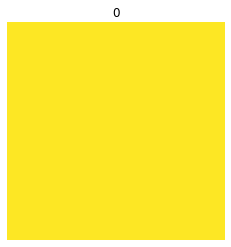

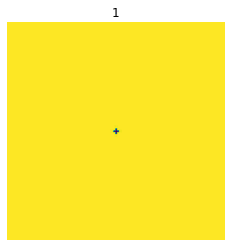

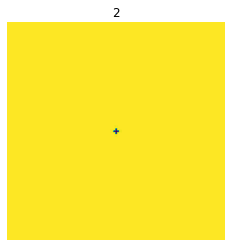

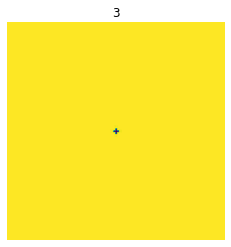

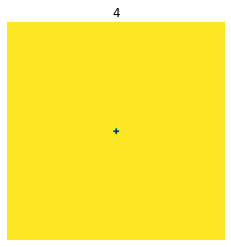

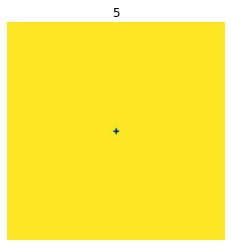

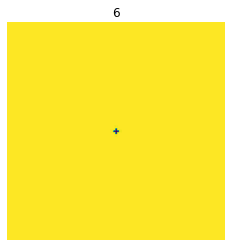

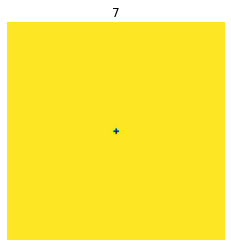

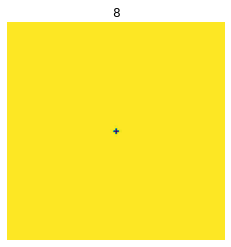

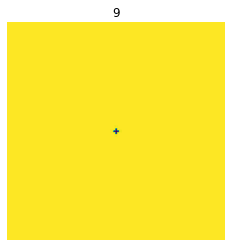

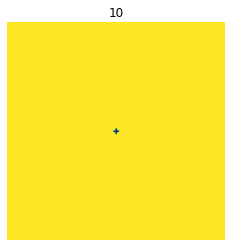

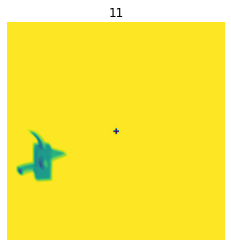

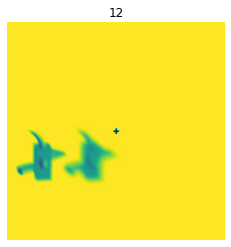

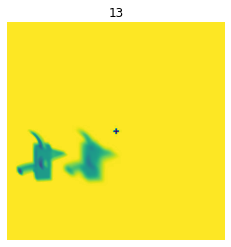

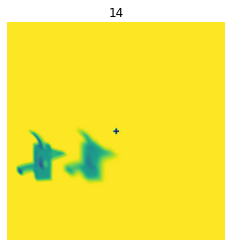

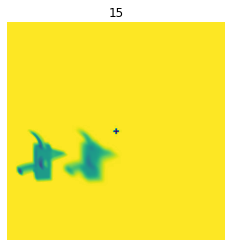

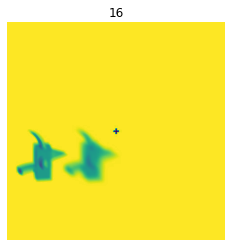

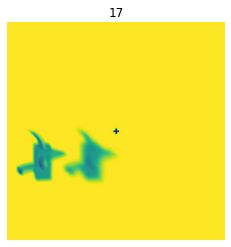

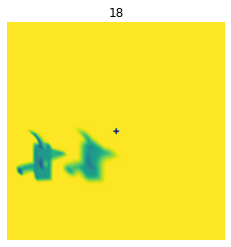

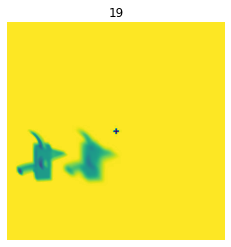

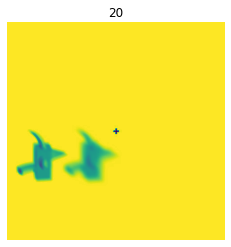

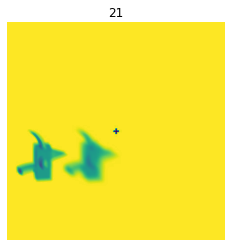

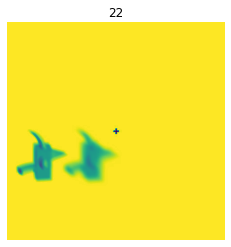

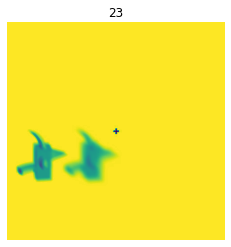

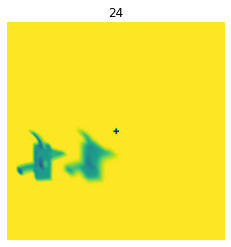

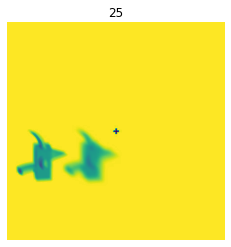

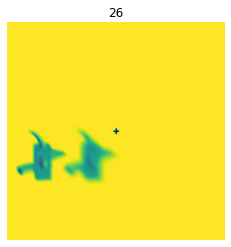

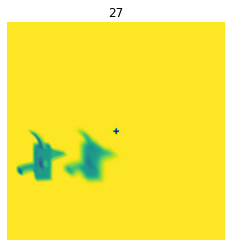

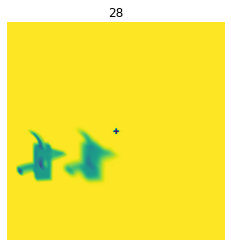

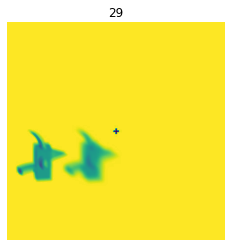

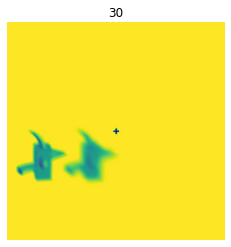

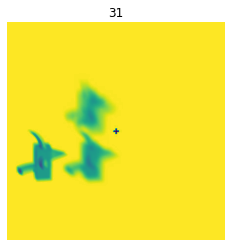

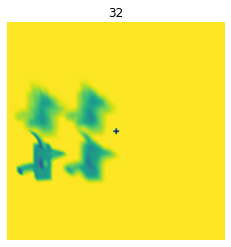

In [452]:
saccades = np.zeros([33, 2], dtype=int)
saccades[12] = [-100, 0]
saccades[24] = [0, -100]
saccades[32] = [100, 0]
sinfo = np.full([33], '999', dtype=object)
sinfo[[11, 12]] = 'Novel_Objects/G1/G101_resized.jpg'
sinfo[[31, 32]] = 'Novel_Objects/G1/G120_resized.jpg'
slocs = np.zeros([33, 2], dtype=int)
slocs[11] = [-150, -50]
slocs[12] = [-50, -50]
slocs[31] = [-50, 50]
slocs[32] = [-150, 50]
filename = 'test24_'
def generateImage(sinfo, retino_loc):
    img = np.ones([440, 440])
    if sinfo != '999':
        s = np.average(matplotlib.image.imread(sinfo)/255, axis=2)
        x, y = retino_loc
        x = x + 220
        y = 220 - y
        img[y-50:y+50, x-50:x+50] = s
    return img
testimg = generateImage(sinfo[12], retino_loc=[-150, -50])
testimg = np.transpose(np.tile(testimg, (3, 1, 1)), (1, 2, 0))

matplotlib.image.imsave('test4.jpg', np.array(testimg, dtype=float)) 
run(saccades, sinfo, slocs, filename)
for t in range(np.shape(saccades)[0]):
    img = np.average(matplotlib.image.imread(filename + str(t) + 'Mretino.jpg')/255, axis=2)
    plt.imshow(img, cmap='viridis', clim=(0, 1))
    plt.axis('off')
    plt.title(str(t))
    plt.show()

In [30]:
np.random.rand()

0.3113436407175625

In [2]:
int(0.5)

0